In [15]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3,InceptionResNetV2,Xception,NASNetMobile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#create labels
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [18]:

X_train = []
y_train = []
image_size = 224
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)):
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:00<00:00, 266.79it/s]


In [19]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [20]:

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [21]:
#load NASNetMobile
NASNetMobile=NASNetMobile(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


In [22]:
#train the model
tf.random.set_seed(79)
model = NASNetMobile.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=NASNetMobile.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [23]:
# summarize the model
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                           

In [24]:

# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 111s 179ms/step - loss: 1.0701 - accuracy: 0.5367 - val_loss: 1.7858 - val_accuracy: 0.2927
Epoch 2/70
348/348 [==============================] - 57s 163ms/step - loss: 0.6058 - accuracy: 0.7664 - val_loss: 1.5601 - val_accuracy: 0.3537
Epoch 3/70
348/348 [==============================] - 58s 168ms/step - loss: 0.4146 - accuracy: 0.8480 - val_loss: 1.3200 - val_accuracy: 0.4411
Epoch 4/70
348/348 [==============================] - 57s 162ms/step - loss: 0.3016 - accuracy: 0.8950 - val_loss: 1.2457 - val_accuracy: 0.4919
Epoch 5/70
348/348 [==============================] - 57s 163ms/step - loss: 0.2129 - accuracy: 0.9260 - val_loss: 1.1115 - val_accuracy: 0.5407
Epoch 6/70
348/348 [==============================] - 65s 187ms/step - loss: 0.1776 - accuracy: 0.9382 - val_loss: 0.8450 - val_accuracy: 0.6707
Epoch 7/70
348/348 [==============================] - 57s 164ms/step - loss: 0.1243 - accuracy: 0.9576 - val_loss: 0.7725 - val_a

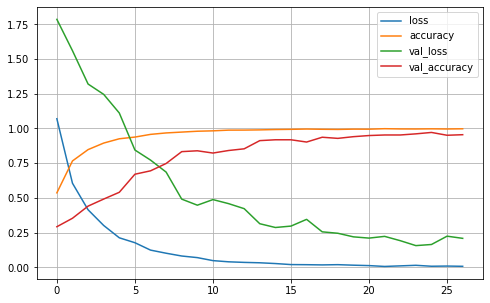

In [25]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [26]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 2s 79ms/step - loss: 0.1567 - accuracy: 0.9614


In [27]:
#print accuracy    
print('Accuracy: %f' % (accuracy*100))

Accuracy: 96.138209


In [28]:
#acuracy and loss
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 96.138 
 loss : 0.157


In [29]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
#pred_labels

In [30]:
pd.Series(pred_labels).value_counts()

glioma_tumor        141
meningioma_tumor    135
pituitary_tumor     133
no_tumor             83
dtype: int64

Text(70.8, 0.5, 'Predicted class')

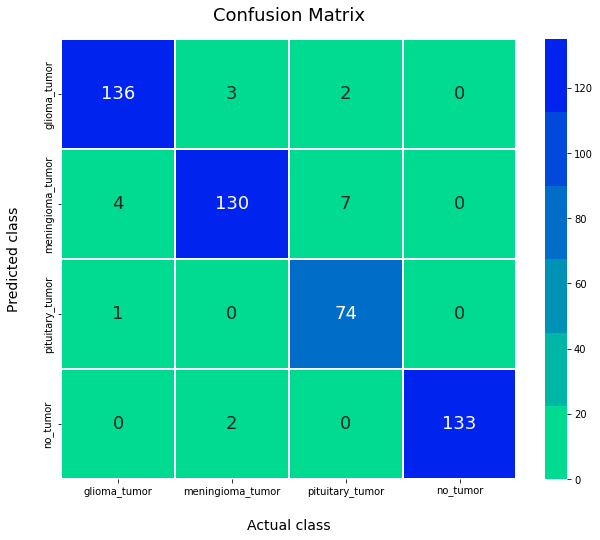

In [31]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r") 
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)


In [32]:
#y_test_labels
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.96      0.96       141
meningioma_tumor       0.96      0.92      0.94       141
 pituitary_tumor       0.89      0.99      0.94        75
        no_tumor       1.00      0.99      0.99       135

        accuracy                           0.96       492
       macro avg       0.95      0.96      0.96       492
    weighted avg       0.96      0.96      0.96       492

